In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length, transform=None):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}  # To store class ID to name mapping

        # Traverse through action categories and their subfolders
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            if not os.path.isdir(category_path):
                continue
            self.class_mapping[label] = category  # Map class ID to category name
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path):
                    frames = sorted(os.listdir(subfolder_path))  # Ensure frames are ordered

                    # Check if there are enough frames
                    if len(frames) >= sequence_length:
                        self.data.append((subfolder_path, frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        # Select frames sequentially from the start, up to sequence_length
        selected_frames = frames[:self.sequence_length]

        sequence = []
        for frame_file in selected_frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                # Try to open the image
                img = Image.open(frame_path).convert("L")  # Convert to grayscale
                if self.transform:
                    img = self.transform(img)

                # Flatten the image to a 1D tensor
                img = img.view(-1)  # Flattening the image to size 4096 (64x64)
                sequence.append(img)

            except (IOError, OSError) as e:
                # Log the error and skip the corrupted frame
                print(f"Warning: Skipping corrupted image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))  # Skip to the next sample

        # Stack frames into a tensor of shape [sequence_length, 4096]
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


In [7]:
# Define augmentations and transformations
transform = transforms.Compose([
    # Spatial augmentations
    # RandomHorizontalFlip(p=0.5),                # Flip frames horizontally with 50% probability
    # RandomRotation(degrees=15),                # Random rotation within ±15 degrees
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),  # Random crop to 64x64, pad if needed

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),  # Adjust brightness/contrast
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Random blur
    
    # Conversion and normalization
    transforms.ToTensor(),                                # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])           # Normalize to [-1, 1]
])

In [8]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 45
batch_size = 16
train_ratio = 0.8  # 80% for training, 20% for validation


In [9]:
# Load the full dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 599
Train set size: 479
Validation set size: 120


In [10]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


In [11]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train the LSTM model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Get outputs for the full sequence
        
        # Only use the last time step's output for classification
        loss = criterion(outputs, labels)  # Use the last timestep output
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy for the last time step
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the LSTM model"""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get outputs for the full sequence
            
            loss = criterion(outputs, labels)  # Use the last timestep output
            running_loss += loss.item()

            # Compute accuracy for the last time step
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5,
                 project='lstm_training', name='test_run'):
    """Train and evaluate the LSTM model for a given number of epochs with W&B logging"""
    # Initialize W&B logging
    wandb.init(project=project, name=name, config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "step_size": step_size,
        "gamma": gamma,
        "optimizer": "Adam",
    },
    )
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []
    learning_rates = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        # Get current learning rate
        current_lr = scheduler.get_last_lr()[0]

        # Record the metrics
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)
        learning_rates.append(current_lr)

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": current_lr
        })

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Step the learning rate scheduler
        scheduler.step()

    # Finish W&B run
    wandb.finish()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates

In [9]:
# Define the Model
class ActionRecognitionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ActionRecognitionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.rnn = nn.GRU(input_size=256, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()  # [batch_size, sequence_length, input_size]
        x = x.view(-1, input_size)  # Flatten sequence into individual frames
        x = self.encoder(x)         # Encode each frame
        x = x.view(batch_size, seq_len, -1)  # Restore sequence structure
        _, h_n = self.rnn(x)        # Pass sequence through GRU
        x = self.classifier(h_n.squeeze(0))  # Classify using the last hidden state
        return x

In [13]:
class ActionRecognitionModel(nn.Module):
    def __init__(self, sequence_length, input_channels, num_classes):
        """
        Args:
            sequence_length (int): Number of frames in input sequence
            input_channels (int): Number of input channels (1 for grayscale)
            num_classes (int): Number of action classes
        """
        super(ActionRecognitionModel, self).__init__()
        
        # Convolutional Encoder
        self.conv_encoder = nn.Sequential(
            # First conv block
            nn.Conv3d(input_channels, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            
            # Second conv block
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            
            # Third conv block
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )
        
        # Recurrent Module (LSTM)
        self.lstm = nn.LSTM(
            input_size=128 * (64 // 8) * (64 // 8),  # Flattened feature map size
            hidden_size=256,  # Hidden layer size
            num_layers=2,     # Number of LSTM layers
            batch_first=True,
            dropout=0.3
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # x shape: [batch_size, sequence_length, channels, height, width]
        # Adjust input to match Conv3d expected shape
        x = x.permute(0, 2, 1, 3, 4)  # [batch_size, channels, sequence_length, height, width]
        
        # Convolutional Encoder
        conv_features = self.conv_encoder(x)
        
        # Prepare for LSTM: flatten spatial dimensions
        batch_size, channels, seq_len, height, width = conv_features.shape
        lstm_input = conv_features.view(batch_size, seq_len, -1)
        
        # Recurrent Module
        lstm_out, _ = self.lstm(lstm_input)
        
        # Take the last time step
        last_time_step = lstm_out[:, -1, :]
        
        # Classifier
        output = self.classifier(last_time_step)
        
        return output

In [15]:
 # Initialize model, loss, and optimizer
model = ActionRecognitionModel(
        sequence_length=15, 
        input_channels=1,  # Grayscale
        num_classes=6
    ).to(device)

model

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


wandb: 🚀 View run epoch_30_lr_1e-3 at: https://wandb.ai/ahmadjaved97/gru/runs/y496qdrd
wandb: Find logs at: wandb/run-20241129_150957-y496qdrd/logs


In [14]:
# Define hyperparameters
input_size = 64 * 64  # Grayscale image flattened
hidden_size = 128
num_classes = len(os.listdir('/home/nfs/inf6/data/datasets/kth_actions'))  # Based on your dataset structure
sequence_length = 15
batch_size = 16
learning_rate = 0.001
num_epochs = 25

In [11]:
model = ActionRecognitionModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)
model

ActionRecognitionModel(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (rnn): GRU(256, 128, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [12]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
num_epochs = 30
learning_rate = 0.001
step_size = 5
gamma = 0.5

# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, train_loader, val_loader, criterion, device,
    num_epochs, learning_rate, step_size, gamma, name='epoch_30_lr_1e-3', project='gru'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  0%|                                                                | 0/30 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [9,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [12,0,0] Ass

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [9]:
class ActionRecognitionModel(nn.Module):
    def __init__(self, input_dim, sequence_length, num_classes):
        super(ActionRecognitionModel, self).__init__()
        # Convolutional encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: [B, 1, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: [B, 32, 32, 32]
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: [B, 64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: [B, 64, 16, 16]
        )
        
        # Calculate flattened feature size from the encoder
        self.feature_size = 64 * 16 * 16  # Channels x Height x Width
        
        # Recurrent module
        self.recurrent = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            dropout=0.5,
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=1),  # Output: [B, 128, sequence_length]
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Output: [B, 128, 1]
            nn.Flatten(),  # Output: [B, 128]
            nn.Linear(128, num_classes),  # Output: [B, num_classes]
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()  # x: [B, seq_len, 4096]
        
        # Reshape for convolutional encoder
        x = x.view(batch_size * seq_len, 1, 64, 64)  # Reshape to [B * seq_len, 1, 64, 64]
        features = self.encoder(x)  # Output: [B * seq_len, 64, 16, 16]
        features = features.view(batch_size, seq_len, -1)  # Output: [B, seq_len, 64 * 16 * 16]
        
        # Recurrent module
        lstm_out, _ = self.recurrent(features)  # Output: [B, seq_len, 256]
        lstm_out = lstm_out.permute(0, 2, 1)  # Permute to [B, 256, seq_len] for 1D Conv
        
        # Classifier
        output = self.classifier(lstm_out)  # Output: [B, num_classes]
        return output

In [10]:
num_classes=6

In [11]:
model = ActionRecognitionModel(input_dim=4096, sequence_length=16, num_classes=num_classes).to(device)

In [12]:
model

ActionRecognitionModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (recurrent): LSTM(16384, 256, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [13]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
num_epochs = 100
learning_rate = 0.001
step_size = 5
gamma = 0.5

# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, train_loader, val_loader, criterion, device,
    num_epochs, learning_rate, step_size, gamma, name='test_2', project='gru'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  1%|▌                                                      | 1/100 [00:11<18:28, 11.20s/it]

Epoch 1/100
Train Loss: 1.7939, Train Accuracy: 0.1336
Eval Loss: 1.7268, Eval Accuracy: 0.3333
Learning Rate: 0.001000


  2%|█                                                      | 2/100 [00:22<17:59, 11.02s/it]

Epoch 2/100
Train Loss: 1.4071, Train Accuracy: 0.3027
Eval Loss: 1.2041, Eval Accuracy: 0.3167
Learning Rate: 0.001000


  3%|█▋                                                     | 3/100 [00:33<17:45, 10.98s/it]

Epoch 3/100
Train Loss: 1.2237, Train Accuracy: 0.3027
Eval Loss: 1.2499, Eval Accuracy: 0.2833
Learning Rate: 0.001000


  4%|██▏                                                    | 4/100 [00:43<17:30, 10.94s/it]

Epoch 4/100
Train Loss: 1.2006, Train Accuracy: 0.3820
Eval Loss: 1.1821, Eval Accuracy: 0.4417
Learning Rate: 0.001000


  5%|██▊                                                    | 5/100 [00:54<17:16, 10.91s/it]

Epoch 5/100
Train Loss: 1.1139, Train Accuracy: 0.3967
Eval Loss: 1.0885, Eval Accuracy: 0.4333
Learning Rate: 0.001000


  6%|███▎                                                   | 6/100 [01:05<17:02, 10.88s/it]

Epoch 6/100
Train Loss: 1.0586, Train Accuracy: 0.4551
Eval Loss: 1.0279, Eval Accuracy: 0.4750
Learning Rate: 0.000500


  7%|███▊                                                   | 7/100 [01:16<16:50, 10.87s/it]

Epoch 7/100
Train Loss: 0.9808, Train Accuracy: 0.4990
Eval Loss: 0.9668, Eval Accuracy: 0.5417
Learning Rate: 0.000500


  8%|████▍                                                  | 8/100 [01:27<16:41, 10.88s/it]

Epoch 8/100
Train Loss: 0.9167, Train Accuracy: 0.5595
Eval Loss: 0.9569, Eval Accuracy: 0.5417
Learning Rate: 0.000500


  9%|████▉                                                  | 9/100 [01:38<16:27, 10.86s/it]

Epoch 9/100
Train Loss: 0.8527, Train Accuracy: 0.5929
Eval Loss: 0.9674, Eval Accuracy: 0.6250
Learning Rate: 0.000500


 10%|█████▍                                                | 10/100 [01:48<16:15, 10.84s/it]

Epoch 10/100
Train Loss: 0.7963, Train Accuracy: 0.6096
Eval Loss: 1.0000, Eval Accuracy: 0.5667
Learning Rate: 0.000500


 11%|█████▉                                                | 11/100 [01:59<16:04, 10.84s/it]

Epoch 11/100
Train Loss: 0.7676, Train Accuracy: 0.6451
Eval Loss: 0.9488, Eval Accuracy: 0.5500
Learning Rate: 0.000250


 12%|██████▍                                               | 12/100 [02:10<15:54, 10.84s/it]

Epoch 12/100
Train Loss: 0.7110, Train Accuracy: 0.6514
Eval Loss: 0.9569, Eval Accuracy: 0.5917
Learning Rate: 0.000250


 13%|███████                                               | 13/100 [02:21<15:40, 10.81s/it]

Epoch 13/100
Train Loss: 0.6912, Train Accuracy: 0.6409
Eval Loss: 0.9072, Eval Accuracy: 0.6083
Learning Rate: 0.000250


 14%|███████▌                                              | 14/100 [02:32<15:31, 10.83s/it]

Epoch 14/100
Train Loss: 0.6663, Train Accuracy: 0.6848
Eval Loss: 0.9569, Eval Accuracy: 0.6083
Learning Rate: 0.000250


 15%|████████                                              | 15/100 [02:43<15:26, 10.90s/it]

Epoch 15/100
Train Loss: 0.6549, Train Accuracy: 0.6534
Eval Loss: 1.0029, Eval Accuracy: 0.6083
Learning Rate: 0.000250


 16%|████████▋                                             | 16/100 [02:54<15:12, 10.87s/it]

Epoch 16/100
Train Loss: 0.6171, Train Accuracy: 0.7161
Eval Loss: 1.0278, Eval Accuracy: 0.6083
Learning Rate: 0.000125


 17%|█████████▏                                            | 17/100 [03:04<15:02, 10.87s/it]

Epoch 17/100
Train Loss: 0.5878, Train Accuracy: 0.7307
Eval Loss: 1.0297, Eval Accuracy: 0.6250
Learning Rate: 0.000125


 18%|█████████▋                                            | 18/100 [03:15<14:53, 10.89s/it]

Epoch 18/100
Train Loss: 0.5714, Train Accuracy: 0.7495
Eval Loss: 1.0347, Eval Accuracy: 0.6333
Learning Rate: 0.000125


 19%|██████████▎                                           | 19/100 [03:26<14:40, 10.87s/it]

Epoch 19/100
Train Loss: 0.5661, Train Accuracy: 0.7578
Eval Loss: 0.9421, Eval Accuracy: 0.6250
Learning Rate: 0.000125


 20%|██████████▊                                           | 20/100 [03:37<14:26, 10.83s/it]

Epoch 20/100
Train Loss: 0.5456, Train Accuracy: 0.7766
Eval Loss: 0.9753, Eval Accuracy: 0.6417
Learning Rate: 0.000125


 21%|███████████▎                                          | 21/100 [03:48<14:14, 10.82s/it]

Epoch 21/100
Train Loss: 0.5287, Train Accuracy: 0.7557
Eval Loss: 0.9458, Eval Accuracy: 0.6333
Learning Rate: 0.000063


 22%|███████████▉                                          | 22/100 [03:59<14:03, 10.82s/it]

Epoch 22/100
Train Loss: 0.5124, Train Accuracy: 0.7912
Eval Loss: 0.9425, Eval Accuracy: 0.6667
Learning Rate: 0.000063


 23%|████████████▍                                         | 23/100 [04:09<13:53, 10.82s/it]

Epoch 23/100
Train Loss: 0.4986, Train Accuracy: 0.8079
Eval Loss: 0.9637, Eval Accuracy: 0.6417
Learning Rate: 0.000063


 24%|████████████▉                                         | 24/100 [04:20<13:39, 10.78s/it]

Epoch 24/100
Train Loss: 0.4896, Train Accuracy: 0.8163
Eval Loss: 0.9945, Eval Accuracy: 0.6333
Learning Rate: 0.000063


 25%|█████████████▌                                        | 25/100 [04:31<13:28, 10.79s/it]

Epoch 25/100
Train Loss: 0.4848, Train Accuracy: 0.8142
Eval Loss: 0.9129, Eval Accuracy: 0.6417
Learning Rate: 0.000063


 26%|██████████████                                        | 26/100 [04:42<13:16, 10.76s/it]

Epoch 26/100
Train Loss: 0.4760, Train Accuracy: 0.8330
Eval Loss: 0.9263, Eval Accuracy: 0.6417
Learning Rate: 0.000031


 27%|██████████████▌                                       | 27/100 [04:52<13:03, 10.74s/it]

Epoch 27/100
Train Loss: 0.4735, Train Accuracy: 0.8267
Eval Loss: 0.9520, Eval Accuracy: 0.6417
Learning Rate: 0.000031


 28%|███████████████                                       | 28/100 [05:03<12:56, 10.79s/it]

Epoch 28/100
Train Loss: 0.4648, Train Accuracy: 0.8497
Eval Loss: 0.9904, Eval Accuracy: 0.6333
Learning Rate: 0.000031


 29%|███████████████▋                                      | 29/100 [05:14<12:48, 10.83s/it]

Epoch 29/100
Train Loss: 0.4637, Train Accuracy: 0.8413
Eval Loss: 0.9830, Eval Accuracy: 0.6333
Learning Rate: 0.000031


 30%|████████████████▏                                     | 30/100 [05:25<12:38, 10.84s/it]

Epoch 30/100
Train Loss: 0.4615, Train Accuracy: 0.8413
Eval Loss: 0.9519, Eval Accuracy: 0.6417
Learning Rate: 0.000031


 31%|████████████████▋                                     | 31/100 [05:36<12:27, 10.83s/it]

Epoch 31/100
Train Loss: 0.4558, Train Accuracy: 0.8413
Eval Loss: 0.9660, Eval Accuracy: 0.6500
Learning Rate: 0.000016


 32%|█████████████████▎                                    | 32/100 [05:47<12:16, 10.83s/it]

Epoch 32/100
Train Loss: 0.4500, Train Accuracy: 0.8476
Eval Loss: 0.9663, Eval Accuracy: 0.6417
Learning Rate: 0.000016


 33%|█████████████████▊                                    | 33/100 [05:58<12:08, 10.87s/it]

Epoch 33/100
Train Loss: 0.4482, Train Accuracy: 0.8476
Eval Loss: 0.9691, Eval Accuracy: 0.6500
Learning Rate: 0.000016


 34%|██████████████████▎                                   | 34/100 [06:08<11:54, 10.83s/it]

Epoch 34/100
Train Loss: 0.4455, Train Accuracy: 0.8518
Eval Loss: 0.9687, Eval Accuracy: 0.6500
Learning Rate: 0.000016


 35%|██████████████████▉                                   | 35/100 [06:19<11:47, 10.89s/it]

Epoch 35/100
Train Loss: 0.4403, Train Accuracy: 0.8518
Eval Loss: 0.9759, Eval Accuracy: 0.6500
Learning Rate: 0.000016


 36%|███████████████████▍                                  | 36/100 [06:30<11:35, 10.87s/it]

Epoch 36/100
Train Loss: 0.4388, Train Accuracy: 0.8476
Eval Loss: 0.9682, Eval Accuracy: 0.6500
Learning Rate: 0.000008


 37%|███████████████████▉                                  | 37/100 [06:41<11:24, 10.87s/it]

Epoch 37/100
Train Loss: 0.4401, Train Accuracy: 0.8601
Eval Loss: 0.9604, Eval Accuracy: 0.6500
Learning Rate: 0.000008


 38%|████████████████████▌                                 | 38/100 [06:52<11:13, 10.86s/it]

Epoch 38/100
Train Loss: 0.4397, Train Accuracy: 0.8580
Eval Loss: 0.9831, Eval Accuracy: 0.6417
Learning Rate: 0.000008


 39%|█████████████████████                                 | 39/100 [07:03<11:05, 10.91s/it]

Epoch 39/100
Train Loss: 0.4390, Train Accuracy: 0.8455
Eval Loss: 0.9663, Eval Accuracy: 0.6417
Learning Rate: 0.000008


 40%|█████████████████████▌                                | 40/100 [07:14<10:52, 10.88s/it]

Epoch 40/100
Train Loss: 0.4388, Train Accuracy: 0.8539
Eval Loss: 0.9455, Eval Accuracy: 0.6500
Learning Rate: 0.000008


 41%|██████████████████████▏                               | 41/100 [07:25<10:45, 10.93s/it]

Epoch 41/100
Train Loss: 0.4320, Train Accuracy: 0.8706
Eval Loss: 0.9553, Eval Accuracy: 0.6417
Learning Rate: 0.000004


 42%|██████████████████████▋                               | 42/100 [07:36<10:35, 10.95s/it]

Epoch 42/100
Train Loss: 0.4346, Train Accuracy: 0.8476
Eval Loss: 0.9584, Eval Accuracy: 0.6417
Learning Rate: 0.000004


 43%|███████████████████████▏                              | 43/100 [07:47<10:21, 10.91s/it]

Epoch 43/100
Train Loss: 0.4348, Train Accuracy: 0.8601
Eval Loss: 0.9804, Eval Accuracy: 0.6333
Learning Rate: 0.000004


 44%|███████████████████████▊                              | 44/100 [07:57<10:10, 10.90s/it]

Epoch 44/100
Train Loss: 0.4364, Train Accuracy: 0.8643
Eval Loss: 0.9531, Eval Accuracy: 0.6333
Learning Rate: 0.000004


 45%|████████████████████████▎                             | 45/100 [08:08<09:59, 10.90s/it]

Epoch 45/100
Train Loss: 0.4299, Train Accuracy: 0.8539
Eval Loss: 0.9641, Eval Accuracy: 0.6417
Learning Rate: 0.000004


 46%|████████████████████████▊                             | 46/100 [08:19<09:49, 10.91s/it]

Epoch 46/100
Train Loss: 0.4273, Train Accuracy: 0.8768
Eval Loss: 0.9030, Eval Accuracy: 0.6667
Learning Rate: 0.000002


 47%|█████████████████████████▍                            | 47/100 [08:31<09:51, 11.16s/it]

Epoch 47/100
Train Loss: 0.4323, Train Accuracy: 0.8601
Eval Loss: 0.9504, Eval Accuracy: 0.6417
Learning Rate: 0.000002


 48%|█████████████████████████▉                            | 48/100 [08:42<09:33, 11.03s/it]

Epoch 48/100
Train Loss: 0.4322, Train Accuracy: 0.8559
Eval Loss: 0.9629, Eval Accuracy: 0.6417
Learning Rate: 0.000002


 49%|██████████████████████████▍                           | 49/100 [08:53<09:20, 10.99s/it]

Epoch 49/100
Train Loss: 0.4336, Train Accuracy: 0.8622
Eval Loss: 1.0011, Eval Accuracy: 0.6417
Learning Rate: 0.000002


 50%|███████████████████████████                           | 50/100 [09:04<09:15, 11.10s/it]

Epoch 50/100
Train Loss: 0.4279, Train Accuracy: 0.8664
Eval Loss: 0.9740, Eval Accuracy: 0.6500
Learning Rate: 0.000002


 51%|███████████████████████████▌                          | 51/100 [09:15<08:59, 11.01s/it]

Epoch 51/100
Train Loss: 0.4345, Train Accuracy: 0.8601
Eval Loss: 0.9242, Eval Accuracy: 0.6500
Learning Rate: 0.000001


 52%|████████████████████████████                          | 52/100 [09:26<08:46, 10.97s/it]

Epoch 52/100
Train Loss: 0.4290, Train Accuracy: 0.8664
Eval Loss: 0.9408, Eval Accuracy: 0.6333
Learning Rate: 0.000001


 53%|████████████████████████████▌                         | 53/100 [09:36<08:33, 10.92s/it]

Epoch 53/100
Train Loss: 0.4310, Train Accuracy: 0.8747
Eval Loss: 0.9447, Eval Accuracy: 0.6417
Learning Rate: 0.000001


 54%|█████████████████████████████▏                        | 54/100 [09:48<08:23, 10.95s/it]

Epoch 54/100
Train Loss: 0.4288, Train Accuracy: 0.8727
Eval Loss: 0.9514, Eval Accuracy: 0.6417
Learning Rate: 0.000001


 55%|█████████████████████████████▋                        | 55/100 [09:59<08:15, 11.00s/it]

Epoch 55/100
Train Loss: 0.4329, Train Accuracy: 0.8601
Eval Loss: 0.9131, Eval Accuracy: 0.6417
Learning Rate: 0.000001


 56%|██████████████████████████████▏                       | 56/100 [10:10<08:04, 11.00s/it]

Epoch 56/100
Train Loss: 0.4300, Train Accuracy: 0.8685
Eval Loss: 0.9367, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 57%|██████████████████████████████▊                       | 57/100 [10:21<07:53, 11.02s/it]

Epoch 57/100
Train Loss: 0.4327, Train Accuracy: 0.8643
Eval Loss: 0.9110, Eval Accuracy: 0.6583
Learning Rate: 0.000000


 58%|███████████████████████████████▎                      | 58/100 [10:31<07:39, 10.94s/it]

Epoch 58/100
Train Loss: 0.4295, Train Accuracy: 0.8664
Eval Loss: 0.9507, Eval Accuracy: 0.6333
Learning Rate: 0.000000


 59%|███████████████████████████████▊                      | 59/100 [10:42<07:28, 10.95s/it]

Epoch 59/100
Train Loss: 0.4312, Train Accuracy: 0.8643
Eval Loss: 0.9612, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 60%|████████████████████████████████▍                     | 60/100 [10:53<07:18, 10.95s/it]

Epoch 60/100
Train Loss: 0.4274, Train Accuracy: 0.8476
Eval Loss: 0.9096, Eval Accuracy: 0.6583
Learning Rate: 0.000000


 61%|████████████████████████████████▉                     | 61/100 [11:04<07:06, 10.93s/it]

Epoch 61/100
Train Loss: 0.4224, Train Accuracy: 0.8727
Eval Loss: 0.9731, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 62%|█████████████████████████████████▍                    | 62/100 [11:15<06:54, 10.90s/it]

Epoch 62/100
Train Loss: 0.4283, Train Accuracy: 0.8727
Eval Loss: 0.9733, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 63%|██████████████████████████████████                    | 63/100 [11:26<06:43, 10.89s/it]

Epoch 63/100
Train Loss: 0.4277, Train Accuracy: 0.8664
Eval Loss: 0.9599, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 64%|██████████████████████████████████▌                   | 64/100 [11:37<06:33, 10.92s/it]

Epoch 64/100
Train Loss: 0.4256, Train Accuracy: 0.8664
Eval Loss: 0.9555, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 65%|███████████████████████████████████                   | 65/100 [11:48<06:21, 10.89s/it]

Epoch 65/100
Train Loss: 0.4315, Train Accuracy: 0.8747
Eval Loss: 0.9490, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 66%|███████████████████████████████████▋                  | 66/100 [11:59<06:09, 10.86s/it]

Epoch 66/100
Train Loss: 0.4302, Train Accuracy: 0.8664
Eval Loss: 0.9527, Eval Accuracy: 0.6333
Learning Rate: 0.000000


 67%|████████████████████████████████████▏                 | 67/100 [12:09<05:58, 10.85s/it]

Epoch 67/100
Train Loss: 0.4257, Train Accuracy: 0.8727
Eval Loss: 0.9637, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 68%|████████████████████████████████████▋                 | 68/100 [12:20<05:47, 10.84s/it]

Epoch 68/100
Train Loss: 0.4247, Train Accuracy: 0.8643
Eval Loss: 0.9343, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 69%|█████████████████████████████████████▎                | 69/100 [12:31<05:36, 10.87s/it]

Epoch 69/100
Train Loss: 0.4258, Train Accuracy: 0.8747
Eval Loss: 0.9574, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 70%|█████████████████████████████████████▊                | 70/100 [12:42<05:26, 10.88s/it]

Epoch 70/100
Train Loss: 0.4287, Train Accuracy: 0.8685
Eval Loss: 0.9810, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 71%|██████████████████████████████████████▎               | 71/100 [12:53<05:16, 10.90s/it]

Epoch 71/100
Train Loss: 0.4289, Train Accuracy: 0.8559
Eval Loss: 0.9524, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 72%|██████████████████████████████████████▉               | 72/100 [13:04<05:04, 10.87s/it]

Epoch 72/100
Train Loss: 0.4310, Train Accuracy: 0.8601
Eval Loss: 0.9600, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 73%|███████████████████████████████████████▍              | 73/100 [13:15<04:54, 10.91s/it]

Epoch 73/100
Train Loss: 0.4300, Train Accuracy: 0.8768
Eval Loss: 0.9613, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 74%|███████████████████████████████████████▉              | 74/100 [13:26<04:43, 10.91s/it]

Epoch 74/100
Train Loss: 0.4267, Train Accuracy: 0.8559
Eval Loss: 0.9497, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 75%|████████████████████████████████████████▌             | 75/100 [13:36<04:31, 10.87s/it]

Epoch 75/100
Train Loss: 0.4259, Train Accuracy: 0.8747
Eval Loss: 0.9566, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 76%|█████████████████████████████████████████             | 76/100 [13:47<04:20, 10.85s/it]

Epoch 76/100
Train Loss: 0.4261, Train Accuracy: 0.8643
Eval Loss: 0.9446, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 77%|█████████████████████████████████████████▌            | 77/100 [13:58<04:09, 10.87s/it]

Epoch 77/100
Train Loss: 0.4265, Train Accuracy: 0.8622
Eval Loss: 0.9502, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 78%|██████████████████████████████████████████            | 78/100 [14:09<03:59, 10.90s/it]

Epoch 78/100
Train Loss: 0.4304, Train Accuracy: 0.8643
Eval Loss: 0.9263, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 79%|██████████████████████████████████████████▋           | 79/100 [14:20<03:49, 10.93s/it]

Epoch 79/100
Train Loss: 0.4256, Train Accuracy: 0.8747
Eval Loss: 0.9090, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 80%|███████████████████████████████████████████▏          | 80/100 [14:31<03:37, 10.90s/it]

Epoch 80/100
Train Loss: 0.4340, Train Accuracy: 0.8622
Eval Loss: 0.9671, Eval Accuracy: 0.6333
Learning Rate: 0.000000


 81%|███████████████████████████████████████████▋          | 81/100 [14:42<03:27, 10.93s/it]

Epoch 81/100
Train Loss: 0.4292, Train Accuracy: 0.8727
Eval Loss: 0.9741, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 82%|████████████████████████████████████████████▎         | 82/100 [14:53<03:16, 10.94s/it]

Epoch 82/100
Train Loss: 0.4317, Train Accuracy: 0.8518
Eval Loss: 0.9532, Eval Accuracy: 0.6333
Learning Rate: 0.000000


 83%|████████████████████████████████████████████▊         | 83/100 [15:04<03:05, 10.92s/it]

Epoch 83/100
Train Loss: 0.4247, Train Accuracy: 0.8747
Eval Loss: 0.9629, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 84%|█████████████████████████████████████████████▎        | 84/100 [15:15<02:54, 10.92s/it]

Epoch 84/100
Train Loss: 0.4266, Train Accuracy: 0.8664
Eval Loss: 0.9693, Eval Accuracy: 0.6333
Learning Rate: 0.000000


 85%|█████████████████████████████████████████████▉        | 85/100 [15:26<02:43, 10.90s/it]

Epoch 85/100
Train Loss: 0.4273, Train Accuracy: 0.8664
Eval Loss: 0.9420, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 86%|██████████████████████████████████████████████▍       | 86/100 [15:37<02:32, 10.90s/it]

Epoch 86/100
Train Loss: 0.4266, Train Accuracy: 0.8768
Eval Loss: 0.9373, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 87%|██████████████████████████████████████████████▉       | 87/100 [15:47<02:21, 10.88s/it]

Epoch 87/100
Train Loss: 0.4298, Train Accuracy: 0.8559
Eval Loss: 0.9483, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 88%|███████████████████████████████████████████████▌      | 88/100 [15:58<02:10, 10.88s/it]

Epoch 88/100
Train Loss: 0.4294, Train Accuracy: 0.8622
Eval Loss: 0.9205, Eval Accuracy: 0.6583
Learning Rate: 0.000000


 89%|████████████████████████████████████████████████      | 89/100 [16:09<01:59, 10.87s/it]

Epoch 89/100
Train Loss: 0.4257, Train Accuracy: 0.8706
Eval Loss: 0.9586, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 90%|████████████████████████████████████████████████▌     | 90/100 [16:20<01:48, 10.88s/it]

Epoch 90/100
Train Loss: 0.4260, Train Accuracy: 0.8706
Eval Loss: 0.9481, Eval Accuracy: 0.6333
Learning Rate: 0.000000


 91%|█████████████████████████████████████████████████▏    | 91/100 [16:31<01:37, 10.86s/it]

Epoch 91/100
Train Loss: 0.4263, Train Accuracy: 0.8706
Eval Loss: 0.9186, Eval Accuracy: 0.6583
Learning Rate: 0.000000


 92%|█████████████████████████████████████████████████▋    | 92/100 [16:42<01:27, 10.90s/it]

Epoch 92/100
Train Loss: 0.4265, Train Accuracy: 0.8580
Eval Loss: 0.9743, Eval Accuracy: 0.6500
Learning Rate: 0.000000


 93%|██████████████████████████████████████████████████▏   | 93/100 [16:53<01:16, 10.94s/it]

Epoch 93/100
Train Loss: 0.4294, Train Accuracy: 0.8643
Eval Loss: 0.9526, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 94%|██████████████████████████████████████████████████▊   | 94/100 [17:04<01:05, 10.93s/it]

Epoch 94/100
Train Loss: 0.4261, Train Accuracy: 0.8580
Eval Loss: 0.9244, Eval Accuracy: 0.6250
Learning Rate: 0.000000


 95%|███████████████████████████████████████████████████▎  | 95/100 [17:15<00:54, 10.97s/it]

Epoch 95/100
Train Loss: 0.4296, Train Accuracy: 0.8685
Eval Loss: 0.9499, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 96%|███████████████████████████████████████████████████▊  | 96/100 [17:26<00:44, 11.00s/it]

Epoch 96/100
Train Loss: 0.4314, Train Accuracy: 0.8601
Eval Loss: 0.9434, Eval Accuracy: 0.6333
Learning Rate: 0.000000


 97%|████████████████████████████████████████████████████▍ | 97/100 [17:37<00:32, 10.96s/it]

Epoch 97/100
Train Loss: 0.4310, Train Accuracy: 0.8601
Eval Loss: 0.9302, Eval Accuracy: 0.6583
Learning Rate: 0.000000


 98%|████████████████████████████████████████████████████▉ | 98/100 [17:47<00:21, 10.90s/it]

Epoch 98/100
Train Loss: 0.4315, Train Accuracy: 0.8601
Eval Loss: 0.9675, Eval Accuracy: 0.6417
Learning Rate: 0.000000


 99%|█████████████████████████████████████████████████████▍| 99/100 [17:59<00:10, 10.97s/it]

Epoch 99/100
Train Loss: 0.4287, Train Accuracy: 0.8622
Eval Loss: 0.9101, Eval Accuracy: 0.6417
Learning Rate: 0.000000


100%|█████████████████████████████████████████████████████| 100/100 [18:10<00:00, 10.90s/it]

Epoch 100/100
Train Loss: 0.4270, Train Accuracy: 0.8727
Eval Loss: 0.9676, Eval Accuracy: 0.6333
Learning Rate: 0.000000


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
eval_accuracy,▁▂▄▄▇▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇█▇█▇▇▇█
eval_loss,█▅▄▂▂▂▂▄▂▃▂▂▂▂▂▃▁▂▁▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂
learning_rate,███▄▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▅▆▆▆▇▆▇▇█▇▇█████████████████████████
train_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
eval_accuracy,0.63333
eval_loss,0.96763
learning_rate,0.0
train_accuracy,0.87265


In [14]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

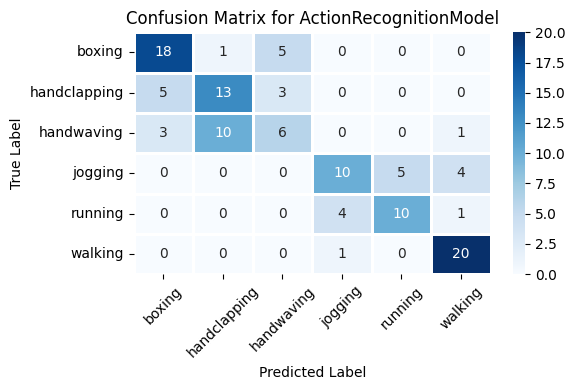

In [15]:
# Function to evaluate model and compute predictions
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            # Reshape and move to device
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(sequences)
            preds = torch.argmax(outputs, dim=1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="ActionRecognitionModel")

In [12]:
class ComplexActionRecognitionModel(nn.Module):
    def __init__(self, sequence_length, input_dim=64*64, num_classes=6):
        super(ComplexActionRecognitionModel, self).__init__()
        self.sequence_length = sequence_length

        # Convolutional Encoder
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (64, 32, 32)
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (128, 16, 16)
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Output: (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (256, 8, 8)
            nn.Dropout(0.4),

            # # Block 4
            # nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Output: (512, 8, 8)
            # nn.BatchNorm2d(512),
            # nn.ReLU(),
            # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # Output: (512, 8, 8)
            # nn.BatchNorm2d(512),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (512, 4, 4)
        )

        # Recurrent Module
        self.rnn = nn.LSTM(
            input_size=256*8*8,  # Flattened size from encoder
            hidden_size=256,  # Hidden state size
            num_layers=2,
            batch_first=True,  # Batch is the first dimension
            dropout=0.3
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=1),  # Temporal conv
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Reduce sequence length to 1
            nn.Flatten(),  # Flatten the output
            nn.Linear(128, num_classes)  # Final classification layer
        )

    def forward(self, x):
        # x: [batch_size, sequence_length, 64*64]
        batch_size, seq_len, _ = x.size()
        
        # Reshape and encode each frame
        x = x.view(batch_size * seq_len, 1, 64, 64)  # Reshape to (batch_size * sequence_length, 1, 64, 64)
        x = self.encoder(x)  # Pass through convolutional encoder
        x = x.view(batch_size, seq_len, -1)  # Reshape to (batch_size, sequence_length, 512*4*4)
        
        # Recurrent Module
        x, _ = self.rnn(x)  # LSTM output shape: (batch_size, sequence_length, 256)
        
        # Classifier
        x = x.transpose(1, 2)  # Change shape to (batch_size, 256, sequence_length) for Conv1d
        x = self.classifier(x)  # Output shape: (batch_size, num_classes)
        
        return x

In [14]:
num_classes=6

In [15]:
model = ComplexActionRecognitionModel(input_dim=4096, sequence_length=16, num_classes=num_classes).to(device)
model

ComplexActionRecognitionModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters
num_epochs = 100
learning_rate = 0.001
step_size = 5
gamma = 0.5


# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, train_loader, val_loader, criterion, device,
    num_epochs, learning_rate, step_size, gamma, name='complex', project='gru'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  1%|▌                                                      | 1/100 [00:15<26:14, 15.91s/it]

Epoch 1/100
Train Loss: 1.3602, Train Accuracy: 0.3278
Eval Loss: 3.1104, Eval Accuracy: 0.1833
Learning Rate: 0.001000


  2%|█                                                      | 2/100 [00:29<23:50, 14.60s/it]

Epoch 2/100
Train Loss: 1.1000, Train Accuracy: 0.4405
Eval Loss: 1.1039, Eval Accuracy: 0.3833
Learning Rate: 0.001000


  3%|█▋                                                     | 3/100 [00:43<22:55, 14.18s/it]

Epoch 3/100
Train Loss: 1.0029, Train Accuracy: 0.5031
Eval Loss: 1.0166, Eval Accuracy: 0.4833
Learning Rate: 0.001000


  4%|██▏                                                    | 4/100 [00:56<22:21, 13.97s/it]

Epoch 4/100
Train Loss: 0.9933, Train Accuracy: 0.4823
Eval Loss: 0.9917, Eval Accuracy: 0.4583
Learning Rate: 0.001000


  5%|██▊                                                    | 5/100 [01:10<22:09, 13.99s/it]

Epoch 5/100
Train Loss: 0.9286, Train Accuracy: 0.5365
Eval Loss: 0.9712, Eval Accuracy: 0.4667
Learning Rate: 0.001000


  6%|███▎                                                   | 6/100 [01:24<21:45, 13.89s/it]

Epoch 6/100
Train Loss: 0.8468, Train Accuracy: 0.5950
Eval Loss: 0.9157, Eval Accuracy: 0.5000
Learning Rate: 0.000500


  7%|███▊                                                   | 7/100 [01:38<21:30, 13.88s/it]

Epoch 7/100
Train Loss: 0.7641, Train Accuracy: 0.6367
Eval Loss: 0.8873, Eval Accuracy: 0.5333
Learning Rate: 0.000500


  8%|████▍                                                  | 8/100 [01:52<21:14, 13.85s/it]

Epoch 8/100
Train Loss: 0.7411, Train Accuracy: 0.6430
Eval Loss: 0.8969, Eval Accuracy: 0.5917
Learning Rate: 0.000500


  9%|████▉                                                  | 9/100 [02:06<20:56, 13.81s/it]

Epoch 9/100
Train Loss: 0.6968, Train Accuracy: 0.6367
Eval Loss: 0.8215, Eval Accuracy: 0.5583
Learning Rate: 0.000500


 10%|█████▍                                                | 10/100 [02:19<20:40, 13.78s/it]

Epoch 10/100
Train Loss: 0.6133, Train Accuracy: 0.6952
Eval Loss: 0.7681, Eval Accuracy: 0.5917
Learning Rate: 0.000500


 11%|█████▉                                                | 11/100 [02:33<20:29, 13.82s/it]

Epoch 11/100
Train Loss: 0.5714, Train Accuracy: 0.7203
Eval Loss: 0.7256, Eval Accuracy: 0.6083
Learning Rate: 0.000250


 12%|██████▍                                               | 12/100 [02:47<20:14, 13.80s/it]

Epoch 12/100
Train Loss: 0.5283, Train Accuracy: 0.7349
Eval Loss: 0.7961, Eval Accuracy: 0.5833
Learning Rate: 0.000250


 13%|███████                                               | 13/100 [03:01<20:01, 13.81s/it]

Epoch 13/100
Train Loss: 0.4966, Train Accuracy: 0.7328
Eval Loss: 0.8251, Eval Accuracy: 0.6000
Learning Rate: 0.000250


 14%|███████▌                                              | 14/100 [03:15<19:49, 13.83s/it]

Epoch 14/100
Train Loss: 0.5157, Train Accuracy: 0.7328
Eval Loss: 0.8179, Eval Accuracy: 0.6250
Learning Rate: 0.000250


 15%|████████                                              | 15/100 [03:28<19:35, 13.83s/it]

Epoch 15/100
Train Loss: 0.5520, Train Accuracy: 0.6868
Eval Loss: 0.7218, Eval Accuracy: 0.5917
Learning Rate: 0.000250


 16%|████████▋                                             | 16/100 [03:42<19:21, 13.83s/it]

Epoch 16/100
Train Loss: 0.4511, Train Accuracy: 0.7537
Eval Loss: 0.6907, Eval Accuracy: 0.6167
Learning Rate: 0.000125


 17%|█████████▏                                            | 17/100 [03:56<19:11, 13.87s/it]

Epoch 17/100
Train Loss: 0.4354, Train Accuracy: 0.7704
Eval Loss: 0.7680, Eval Accuracy: 0.5500
Learning Rate: 0.000125


 18%|█████████▋                                            | 18/100 [04:10<18:56, 13.86s/it]

Epoch 18/100
Train Loss: 0.4307, Train Accuracy: 0.7766
Eval Loss: 0.7544, Eval Accuracy: 0.5833
Learning Rate: 0.000125


 19%|██████████▎                                           | 19/100 [04:24<18:41, 13.85s/it]

Epoch 19/100
Train Loss: 0.4000, Train Accuracy: 0.7745
Eval Loss: 0.7519, Eval Accuracy: 0.6250
Learning Rate: 0.000125


 20%|██████████▊                                           | 20/100 [04:38<18:25, 13.82s/it]

Epoch 20/100
Train Loss: 0.4013, Train Accuracy: 0.7850
Eval Loss: 0.7693, Eval Accuracy: 0.6000
Learning Rate: 0.000125


 21%|███████████▎                                          | 21/100 [04:51<18:10, 13.81s/it]

Epoch 21/100
Train Loss: 0.3754, Train Accuracy: 0.8017
Eval Loss: 0.7775, Eval Accuracy: 0.5917
Learning Rate: 0.000063


 22%|███████████▉                                          | 22/100 [05:05<17:58, 13.83s/it]

Epoch 22/100
Train Loss: 0.3555, Train Accuracy: 0.8121
Eval Loss: 0.7785, Eval Accuracy: 0.5833
Learning Rate: 0.000063


 23%|████████████▍                                         | 23/100 [05:19<17:46, 13.84s/it]

Epoch 23/100
Train Loss: 0.3583, Train Accuracy: 0.8121
Eval Loss: 0.7763, Eval Accuracy: 0.6083
Learning Rate: 0.000063


 24%|████████████▉                                         | 24/100 [05:33<17:33, 13.86s/it]

Epoch 24/100
Train Loss: 0.3582, Train Accuracy: 0.8163
Eval Loss: 0.8424, Eval Accuracy: 0.6000
Learning Rate: 0.000063


 25%|█████████████▌                                        | 25/100 [05:47<17:18, 13.84s/it]

Epoch 25/100
Train Loss: 0.3448, Train Accuracy: 0.8184
Eval Loss: 0.8082, Eval Accuracy: 0.5917
Learning Rate: 0.000063


 26%|██████████████                                        | 26/100 [06:01<17:05, 13.86s/it]

Epoch 26/100
Train Loss: 0.3346, Train Accuracy: 0.8163
Eval Loss: 0.8228, Eval Accuracy: 0.5833
Learning Rate: 0.000031


 27%|██████████████▌                                       | 27/100 [06:15<16:52, 13.87s/it]

Epoch 27/100
Train Loss: 0.3427, Train Accuracy: 0.8184
Eval Loss: 0.8180, Eval Accuracy: 0.6083
Learning Rate: 0.000031


 28%|███████████████                                       | 28/100 [06:28<16:36, 13.84s/it]

Epoch 28/100
Train Loss: 0.3404, Train Accuracy: 0.8184
Eval Loss: 0.8255, Eval Accuracy: 0.6083
Learning Rate: 0.000031


 29%|███████████████▋                                      | 29/100 [06:42<16:22, 13.84s/it]

Epoch 29/100
Train Loss: 0.3474, Train Accuracy: 0.8205
Eval Loss: 0.8077, Eval Accuracy: 0.6000
Learning Rate: 0.000031


 30%|████████████████▏                                     | 30/100 [06:56<16:09, 13.85s/it]

Epoch 30/100
Train Loss: 0.3381, Train Accuracy: 0.8225
Eval Loss: 0.8238, Eval Accuracy: 0.6083
Learning Rate: 0.000031


 31%|████████████████▋                                     | 31/100 [07:10<15:56, 13.87s/it]

Epoch 31/100
Train Loss: 0.3233, Train Accuracy: 0.8225
Eval Loss: 0.8185, Eval Accuracy: 0.5917
Learning Rate: 0.000016
